# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

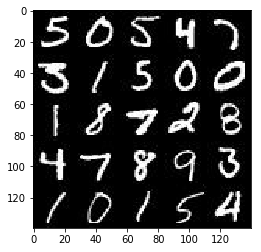

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

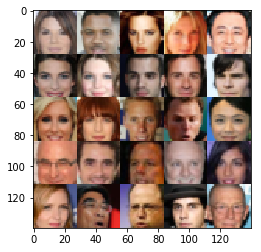

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32) 
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [22]:
def discriminator(images, reuse=False, alpha = 0.01):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', activation=None)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', activation=None)
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        #x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', activation=None)
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        #x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        
        flat = tf.reshape(x3, (-1,  4 * 4 * 256))

        logits = tf.layers.dense(flat, 1, activation=None)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [23]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        
        h1 = tf.layers.dense(z, 3*3*512)
        h1 = tf.reshape(h1, (-1, 3, 3, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
        # 3x3x512
        
        h2 = tf.layers.conv2d_transpose(h1, 256, kernel_size=4, strides=2, padding='same')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
        # 6x6x256
        
        h3 = tf.layers.conv2d_transpose(h2, 128, kernel_size=4, strides=2, padding='valid')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
        #14x14x128
        
        # Output layer
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, kernel_size=5,strides=2, padding='same')
        out = tf.tanh(logits)
        # 28x28x5
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [27]:
def model_loss(input_real, input_z, out_channel_dim, alpha = 0.01):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_fake + d_loss_real
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [28]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [29]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [31]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    _, img_width, img_height, img_channels = data_shape
    real_input_img, z_input, lr = model_inputs(img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input_img, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    losses = []
    n_images = 25        
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1 # next batch
                batch_images *= 2.0 # the image is increasing by double for each layer
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim)) # uniform distribution
                
                # performing d_opt with the feed_dict knowledge
                _ = sess.run(d_opt, feed_dict={real_input_img: batch_images, z_input: z_sample, lr: learning_rate})
                # performing g_opt with the feed_dict knowledge
                _ = sess.run(g_opt, feed_dict={z_input: z_sample, lr: learning_rate})
                
                # Check if is it time to print the Loss or just keep going (skip the print)
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input_img: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                # Showing the generator output based on show_every step
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0106... Generator Loss: 6.4350
Epoch 1/2... Discriminator Loss: 0.0027... Generator Loss: 9.1714
Epoch 1/2... Discriminator Loss: 0.0041... Generator Loss: 6.4853
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 10.4225
Epoch 1/2... Discriminator Loss: 0.0212... Generator Loss: 15.8360
Epoch 1/2... Discriminator Loss: 6.2989... Generator Loss: 0.0023
Epoch 1/2... Discriminator Loss: 0.1968... Generator Loss: 2.3808
Epoch 1/2... Discriminator Loss: 0.3773... Generator Loss: 2.6347
Epoch 1/2... Discriminator Loss: 0.0851... Generator Loss: 5.1873
Epoch 1/2... Discriminator Loss: 0.3357... Generator Loss: 2.7310


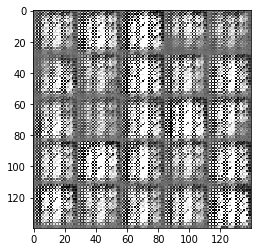

Epoch 1/2... Discriminator Loss: 0.1900... Generator Loss: 2.4664
Epoch 1/2... Discriminator Loss: 0.0805... Generator Loss: 5.5086
Epoch 1/2... Discriminator Loss: 2.0100... Generator Loss: 0.3131
Epoch 1/2... Discriminator Loss: 0.4207... Generator Loss: 2.4813
Epoch 1/2... Discriminator Loss: 0.1526... Generator Loss: 4.6478
Epoch 1/2... Discriminator Loss: 0.1335... Generator Loss: 4.0122
Epoch 1/2... Discriminator Loss: 1.1443... Generator Loss: 1.5703
Epoch 1/2... Discriminator Loss: 0.5706... Generator Loss: 4.3149
Epoch 1/2... Discriminator Loss: 0.3842... Generator Loss: 1.9626
Epoch 1/2... Discriminator Loss: 0.4497... Generator Loss: 1.5376


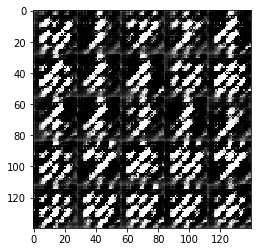

Epoch 1/2... Discriminator Loss: 0.6225... Generator Loss: 1.7226
Epoch 1/2... Discriminator Loss: 0.3674... Generator Loss: 2.4524
Epoch 1/2... Discriminator Loss: 0.4117... Generator Loss: 2.0687
Epoch 1/2... Discriminator Loss: 0.1424... Generator Loss: 4.4056
Epoch 1/2... Discriminator Loss: 1.5620... Generator Loss: 7.0558
Epoch 1/2... Discriminator Loss: 0.5011... Generator Loss: 1.7363
Epoch 1/2... Discriminator Loss: 0.6151... Generator Loss: 1.6746
Epoch 1/2... Discriminator Loss: 2.1875... Generator Loss: 0.2269
Epoch 1/2... Discriminator Loss: 1.3776... Generator Loss: 0.5554
Epoch 1/2... Discriminator Loss: 0.8740... Generator Loss: 0.9048


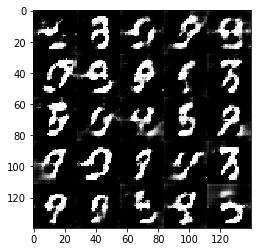

Epoch 1/2... Discriminator Loss: 0.8410... Generator Loss: 1.1037
Epoch 1/2... Discriminator Loss: 0.4884... Generator Loss: 1.8439
Epoch 1/2... Discriminator Loss: 0.8546... Generator Loss: 5.5813
Epoch 1/2... Discriminator Loss: 1.3395... Generator Loss: 0.7815
Epoch 1/2... Discriminator Loss: 0.5362... Generator Loss: 4.7348
Epoch 1/2... Discriminator Loss: 0.6699... Generator Loss: 1.3131
Epoch 1/2... Discriminator Loss: 0.7475... Generator Loss: 1.1669
Epoch 1/2... Discriminator Loss: 0.5669... Generator Loss: 1.9829
Epoch 1/2... Discriminator Loss: 2.1972... Generator Loss: 0.2159
Epoch 1/2... Discriminator Loss: 1.0480... Generator Loss: 0.9135


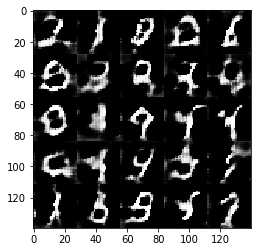

Epoch 1/2... Discriminator Loss: 1.5078... Generator Loss: 3.2928
Epoch 1/2... Discriminator Loss: 0.6531... Generator Loss: 1.5384
Epoch 1/2... Discriminator Loss: 0.7324... Generator Loss: 3.0547
Epoch 1/2... Discriminator Loss: 0.6676... Generator Loss: 1.6665
Epoch 1/2... Discriminator Loss: 0.9344... Generator Loss: 0.9493
Epoch 1/2... Discriminator Loss: 1.0038... Generator Loss: 0.7978
Epoch 1/2... Discriminator Loss: 1.4513... Generator Loss: 0.5037
Epoch 1/2... Discriminator Loss: 1.2150... Generator Loss: 0.5923
Epoch 1/2... Discriminator Loss: 0.8432... Generator Loss: 1.7052
Epoch 1/2... Discriminator Loss: 1.5552... Generator Loss: 0.3317


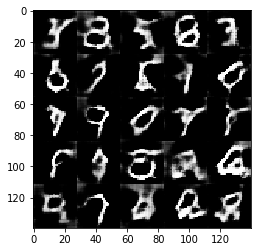

Epoch 1/2... Discriminator Loss: 1.1446... Generator Loss: 0.7361
Epoch 1/2... Discriminator Loss: 1.6362... Generator Loss: 0.3478
Epoch 1/2... Discriminator Loss: 0.8944... Generator Loss: 1.4664
Epoch 1/2... Discriminator Loss: 0.8577... Generator Loss: 1.0241
Epoch 1/2... Discriminator Loss: 0.9100... Generator Loss: 0.9926
Epoch 1/2... Discriminator Loss: 1.0715... Generator Loss: 0.7713
Epoch 1/2... Discriminator Loss: 1.8431... Generator Loss: 0.2972
Epoch 1/2... Discriminator Loss: 0.8656... Generator Loss: 1.2278
Epoch 1/2... Discriminator Loss: 1.6087... Generator Loss: 0.4033
Epoch 1/2... Discriminator Loss: 0.7511... Generator Loss: 1.4199


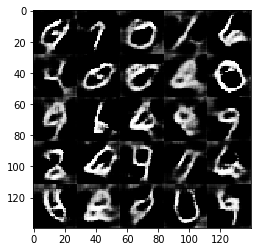

Epoch 1/2... Discriminator Loss: 0.7226... Generator Loss: 1.2004
Epoch 1/2... Discriminator Loss: 0.9431... Generator Loss: 0.9640
Epoch 1/2... Discriminator Loss: 0.7683... Generator Loss: 1.3138
Epoch 1/2... Discriminator Loss: 1.0231... Generator Loss: 0.7846
Epoch 1/2... Discriminator Loss: 1.0403... Generator Loss: 0.6864
Epoch 1/2... Discriminator Loss: 1.1578... Generator Loss: 0.5489
Epoch 1/2... Discriminator Loss: 1.2167... Generator Loss: 2.6515
Epoch 1/2... Discriminator Loss: 1.4428... Generator Loss: 3.1181
Epoch 1/2... Discriminator Loss: 1.2067... Generator Loss: 1.2860
Epoch 1/2... Discriminator Loss: 1.8379... Generator Loss: 0.3269


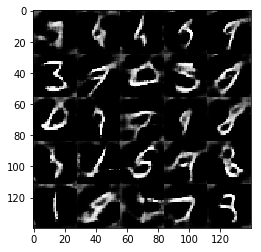

Epoch 1/2... Discriminator Loss: 0.8405... Generator Loss: 1.1208
Epoch 1/2... Discriminator Loss: 0.6391... Generator Loss: 2.5871
Epoch 1/2... Discriminator Loss: 1.0636... Generator Loss: 0.7488
Epoch 1/2... Discriminator Loss: 0.7704... Generator Loss: 2.8482
Epoch 1/2... Discriminator Loss: 0.6341... Generator Loss: 3.2528
Epoch 1/2... Discriminator Loss: 1.0598... Generator Loss: 0.8669
Epoch 1/2... Discriminator Loss: 0.7283... Generator Loss: 1.3452
Epoch 1/2... Discriminator Loss: 0.6340... Generator Loss: 1.2553
Epoch 1/2... Discriminator Loss: 0.8345... Generator Loss: 2.4061
Epoch 1/2... Discriminator Loss: 1.1768... Generator Loss: 0.5727


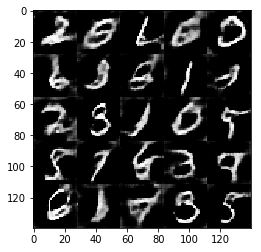

Epoch 1/2... Discriminator Loss: 1.9706... Generator Loss: 0.2848
Epoch 1/2... Discriminator Loss: 0.8891... Generator Loss: 0.8661
Epoch 1/2... Discriminator Loss: 1.2558... Generator Loss: 0.4976
Epoch 1/2... Discriminator Loss: 0.5811... Generator Loss: 2.2236
Epoch 1/2... Discriminator Loss: 0.9660... Generator Loss: 1.0967
Epoch 1/2... Discriminator Loss: 0.7761... Generator Loss: 2.3852
Epoch 1/2... Discriminator Loss: 0.7057... Generator Loss: 1.7445
Epoch 1/2... Discriminator Loss: 0.8051... Generator Loss: 1.2020
Epoch 1/2... Discriminator Loss: 0.5790... Generator Loss: 2.2671
Epoch 1/2... Discriminator Loss: 0.4903... Generator Loss: 1.5403


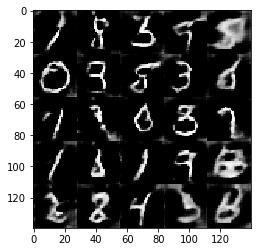

Epoch 1/2... Discriminator Loss: 2.2379... Generator Loss: 0.1699
Epoch 1/2... Discriminator Loss: 0.7358... Generator Loss: 1.4731
Epoch 1/2... Discriminator Loss: 1.7200... Generator Loss: 0.3373
Epoch 2/2... Discriminator Loss: 0.6634... Generator Loss: 1.4372
Epoch 2/2... Discriminator Loss: 1.7766... Generator Loss: 0.3601
Epoch 2/2... Discriminator Loss: 0.3956... Generator Loss: 2.5450
Epoch 2/2... Discriminator Loss: 1.5455... Generator Loss: 3.0468
Epoch 2/2... Discriminator Loss: 0.6959... Generator Loss: 1.3333
Epoch 2/2... Discriminator Loss: 1.6840... Generator Loss: 0.4184
Epoch 2/2... Discriminator Loss: 1.4386... Generator Loss: 0.4488


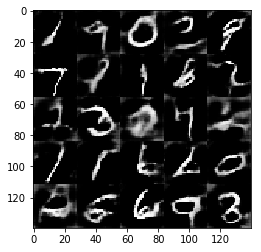

Epoch 2/2... Discriminator Loss: 0.6449... Generator Loss: 3.4776
Epoch 2/2... Discriminator Loss: 1.6555... Generator Loss: 0.3385
Epoch 2/2... Discriminator Loss: 0.7463... Generator Loss: 1.0635
Epoch 2/2... Discriminator Loss: 1.2455... Generator Loss: 2.3465
Epoch 2/2... Discriminator Loss: 0.5143... Generator Loss: 2.0076
Epoch 2/2... Discriminator Loss: 0.6673... Generator Loss: 1.3186
Epoch 2/2... Discriminator Loss: 0.6829... Generator Loss: 1.3465
Epoch 2/2... Discriminator Loss: 1.0923... Generator Loss: 0.7031
Epoch 2/2... Discriminator Loss: 0.2400... Generator Loss: 2.8816
Epoch 2/2... Discriminator Loss: 0.8073... Generator Loss: 1.0485


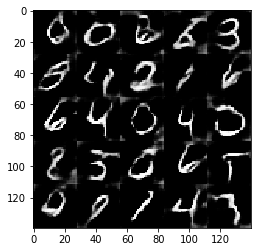

Epoch 2/2... Discriminator Loss: 0.8676... Generator Loss: 0.8615
Epoch 2/2... Discriminator Loss: 1.5029... Generator Loss: 0.3631
Epoch 2/2... Discriminator Loss: 1.8107... Generator Loss: 0.2858
Epoch 2/2... Discriminator Loss: 0.4965... Generator Loss: 2.9420
Epoch 2/2... Discriminator Loss: 1.0759... Generator Loss: 0.7113
Epoch 2/2... Discriminator Loss: 2.4355... Generator Loss: 0.1713
Epoch 2/2... Discriminator Loss: 1.9780... Generator Loss: 0.2747
Epoch 2/2... Discriminator Loss: 1.8727... Generator Loss: 3.4576
Epoch 2/2... Discriminator Loss: 0.8152... Generator Loss: 2.6358
Epoch 2/2... Discriminator Loss: 1.1541... Generator Loss: 0.6298


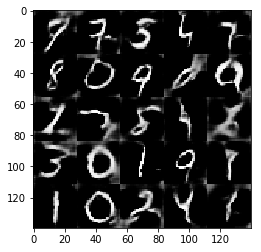

Epoch 2/2... Discriminator Loss: 1.3152... Generator Loss: 0.4781
Epoch 2/2... Discriminator Loss: 1.3971... Generator Loss: 0.4147
Epoch 2/2... Discriminator Loss: 0.7433... Generator Loss: 1.0989
Epoch 2/2... Discriminator Loss: 1.1774... Generator Loss: 0.6718
Epoch 2/2... Discriminator Loss: 0.6295... Generator Loss: 1.2201
Epoch 2/2... Discriminator Loss: 0.8467... Generator Loss: 0.8362
Epoch 2/2... Discriminator Loss: 0.6601... Generator Loss: 2.1361
Epoch 2/2... Discriminator Loss: 1.4939... Generator Loss: 0.4568
Epoch 2/2... Discriminator Loss: 2.0535... Generator Loss: 0.2997
Epoch 2/2... Discriminator Loss: 0.5771... Generator Loss: 2.9352


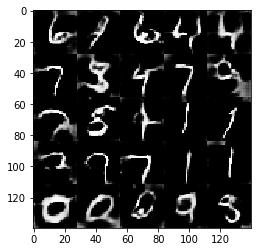

Epoch 2/2... Discriminator Loss: 1.1161... Generator Loss: 0.6753
Epoch 2/2... Discriminator Loss: 0.5501... Generator Loss: 3.3264
Epoch 2/2... Discriminator Loss: 1.2004... Generator Loss: 0.5478
Epoch 2/2... Discriminator Loss: 0.5548... Generator Loss: 1.6831
Epoch 2/2... Discriminator Loss: 0.5383... Generator Loss: 2.9443
Epoch 2/2... Discriminator Loss: 1.0215... Generator Loss: 3.1290
Epoch 2/2... Discriminator Loss: 0.7567... Generator Loss: 1.1674
Epoch 2/2... Discriminator Loss: 1.2713... Generator Loss: 0.4984
Epoch 2/2... Discriminator Loss: 0.5596... Generator Loss: 1.7529
Epoch 2/2... Discriminator Loss: 0.8455... Generator Loss: 0.9817


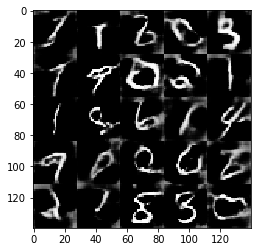

Epoch 2/2... Discriminator Loss: 1.5020... Generator Loss: 0.5206
Epoch 2/2... Discriminator Loss: 0.6332... Generator Loss: 1.5101
Epoch 2/2... Discriminator Loss: 0.9601... Generator Loss: 0.8992
Epoch 2/2... Discriminator Loss: 1.7519... Generator Loss: 0.3812
Epoch 2/2... Discriminator Loss: 0.8251... Generator Loss: 1.6311
Epoch 2/2... Discriminator Loss: 0.9478... Generator Loss: 0.7799
Epoch 2/2... Discriminator Loss: 0.7653... Generator Loss: 1.0493
Epoch 2/2... Discriminator Loss: 1.1442... Generator Loss: 0.6033
Epoch 2/2... Discriminator Loss: 0.7461... Generator Loss: 1.0450
Epoch 2/2... Discriminator Loss: 1.5923... Generator Loss: 4.6337


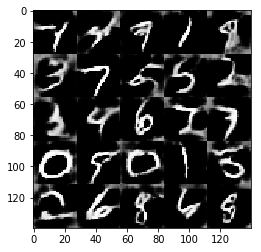

Epoch 2/2... Discriminator Loss: 1.6375... Generator Loss: 0.5030
Epoch 2/2... Discriminator Loss: 1.5744... Generator Loss: 0.4096
Epoch 2/2... Discriminator Loss: 0.5429... Generator Loss: 1.4657
Epoch 2/2... Discriminator Loss: 2.0202... Generator Loss: 0.2617
Epoch 2/2... Discriminator Loss: 0.6480... Generator Loss: 1.6322
Epoch 2/2... Discriminator Loss: 1.4252... Generator Loss: 0.4988
Epoch 2/2... Discriminator Loss: 1.0143... Generator Loss: 0.9189
Epoch 2/2... Discriminator Loss: 1.3464... Generator Loss: 0.4952
Epoch 2/2... Discriminator Loss: 1.0129... Generator Loss: 0.6631
Epoch 2/2... Discriminator Loss: 0.7249... Generator Loss: 1.2736


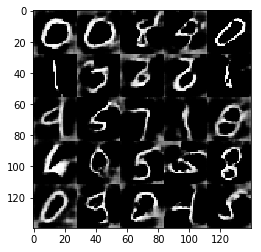

Epoch 2/2... Discriminator Loss: 0.7716... Generator Loss: 1.3605
Epoch 2/2... Discriminator Loss: 1.6455... Generator Loss: 0.3892
Epoch 2/2... Discriminator Loss: 1.1947... Generator Loss: 0.5732
Epoch 2/2... Discriminator Loss: 0.5815... Generator Loss: 3.3660
Epoch 2/2... Discriminator Loss: 0.4420... Generator Loss: 2.6940
Epoch 2/2... Discriminator Loss: 0.4374... Generator Loss: 2.0770
Epoch 2/2... Discriminator Loss: 0.9527... Generator Loss: 0.8086
Epoch 2/2... Discriminator Loss: 0.3980... Generator Loss: 1.9512
Epoch 2/2... Discriminator Loss: 2.4551... Generator Loss: 0.1765
Epoch 2/2... Discriminator Loss: 1.0490... Generator Loss: 0.7650


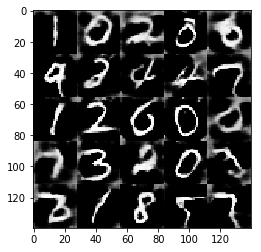

Epoch 2/2... Discriminator Loss: 1.0718... Generator Loss: 0.6882
Epoch 2/2... Discriminator Loss: 0.9697... Generator Loss: 0.8398
Epoch 2/2... Discriminator Loss: 1.8567... Generator Loss: 0.2340
Epoch 2/2... Discriminator Loss: 1.3505... Generator Loss: 0.5272
Epoch 2/2... Discriminator Loss: 0.5138... Generator Loss: 2.6497
Epoch 2/2... Discriminator Loss: 0.4249... Generator Loss: 2.3388
Epoch 2/2... Discriminator Loss: 2.4324... Generator Loss: 0.1615
Epoch 2/2... Discriminator Loss: 0.9955... Generator Loss: 0.8284
Epoch 2/2... Discriminator Loss: 1.2061... Generator Loss: 0.5746
Epoch 2/2... Discriminator Loss: 0.6808... Generator Loss: 1.1548


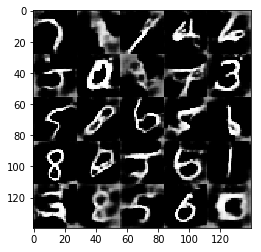

Epoch 2/2... Discriminator Loss: 1.3683... Generator Loss: 0.4619
Epoch 2/2... Discriminator Loss: 1.0974... Generator Loss: 0.6934
Epoch 2/2... Discriminator Loss: 0.7630... Generator Loss: 1.3099
Epoch 2/2... Discriminator Loss: 1.9897... Generator Loss: 0.2277
Epoch 2/2... Discriminator Loss: 1.1178... Generator Loss: 0.6202
Epoch 2/2... Discriminator Loss: 0.9704... Generator Loss: 0.8585
Epoch 2/2... Discriminator Loss: 1.2494... Generator Loss: 0.5756


In [32]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = None
z_dim = None
learning_rate = None
beta1 = None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.